<a href="https://colab.research.google.com/github/rishubhkhurana/CodeRepository/blob/master/Assignment4/facerecogpipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Book Keeping

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz


In [271]:
!rm -rf lfw_funneled 

In [272]:
!rm -rf faces

In [ ]:
!tar -xvf lfw-funneled.tgz

In [12]:
!cp lfw-funneled.tgz /content/drive/My\ Drive/VisionUtils/.

In [4]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [ ]:
!unzip faces.zip

In [278]:
!cp -R faces/* lfw_funneled/.

In [ ]:
!zip -r lfw_funneled.zip lfw_funneled

In [280]:
!cp lfw_funneled.zip /content/drive/My\ Drive/VisionUtils/datasets/.

In [2]:
!cp -r /content/drive/My\ Drive/VisionUtils/datasets/lfw_funneled_aligned.zip .

In [3]:
!unzip /content/lfw_funneled_aligned.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0024.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0027.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0012.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0011.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0006.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0020.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0002.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0003.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0022.jpg  
  inflating: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0026.jpg  
   creating: lfw_funneled_aligned/Romano_Prodi/
  inflating: lfw_funneled_aligned/Romano_Prodi/Romano_Prodi_0003.jpg  
  inflating: lfw_funneled_aligned/Romano_Prodi/Romano_Prodi_

## Importing Libs

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import cv2
import os
import dlib
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN,InceptionResnetV1
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch.optim.lr_scheduler import OneCycleLR
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter,ToTensor, Normalize, CenterCrop
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from fastprogress import progress_bar
from collections import Counter
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['image.cmap'] = 'gray'


In [6]:
import sys
sys.path.append('/content/drive/My Drive/')

In [7]:
from Vision import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Utility Funcs

In [8]:
def show_batch(dl,nrow=8,nimages=32,figsize=(16,16)):
    batch = next(iter(dl))
    img_grid = vutils.make_grid(batch[0][:nimages],normalize=True)
    img_grid = img_grid.numpy().transpose((1,2,0))
    plt.figure(figsize=figsize)
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()

## Face Detection Pipeline Using Dlib

In [5]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_5_face_landmarks.dat.bz2

--2020-08-21 16:01:33--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  1.71MB/s    in 3.2s    

2020-08-21 16:01:36 (1.71 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [9]:
!cp /content/drive/My\ Drive/VisionUtils/faceBlendCommon.py .

In [7]:
faceDetector = dlib.get_frontal_face_detector()

In [10]:
import faceBlendCommon as fc

In [87]:
img_name = 'kohli1.jpg'
img = cv2.imread(img_name)

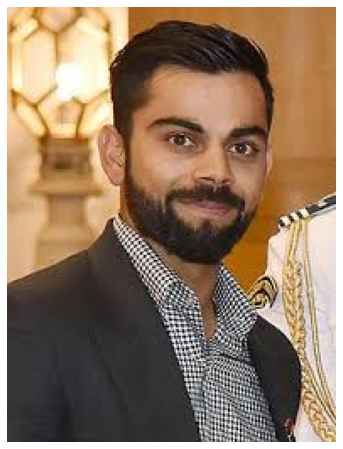

In [88]:
plt.imshow(img[...,::-1])
plt.axis('off')
plt.show()

In [83]:
#img1 = cv2.imread('face2.jpg')
#img = cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA)
facerects = faceDetector(img,0)
rect = facerects[0]
img1 = cv2.rectangle(img,(facerects[0].left(),facerects[0].top()),(facerects[0].right(),facerects[0].bottom()),color=(255,0,0))

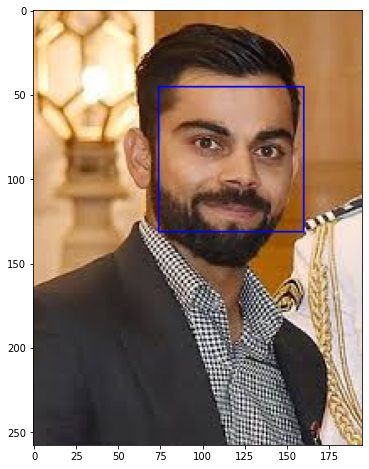

In [72]:
_=plt.imshow(img1[...,::-1])

In [73]:
landmarkPredictor = dlib.shape_predictor('/content/shape_predictor_5_face_landmarks.dat')

In [89]:
points = fc.getLandmarks(faceDetector,landmarkPredictor,img)
points = np.array(points)
img = np.float32(img)/255.

In [90]:
h=160
w=160
imNorm,points = fc.normalizeImagesAndLandmarks((h,w),img,points)
imgNorm = np.uint8(imNorm*255.)

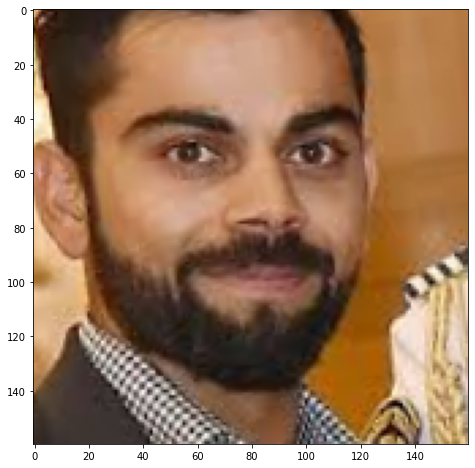

In [91]:
_=plt.imshow(imgNorm[...,::-1])

## Face alignment using MTCNN


In [5]:
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0')

In [10]:
ds = ImageFolder('./lfw_funneled')

In [12]:
len(ds.classes)

5749

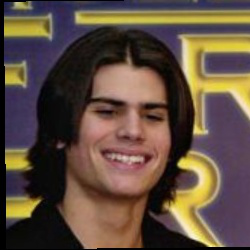

In [25]:
ds[1][0]

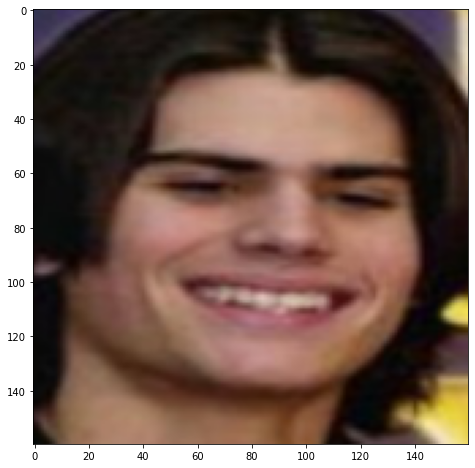

In [26]:
plt.imshow(mtcnn(ds[1][0]).int().numpy().transpose((1,2,0)))
plt.show()

In [41]:
set(os.listdir('/content/lfw_funneled')).difference(set(ds.classes))

set()

## Selecting few classes and saving them

In [291]:
!rm -rf /content/lfw_funneled_aligned

In [292]:
!rm /content/lfw_funneled/*.txt

rm: cannot remove '/content/lfw_funneled/*.txt': No such file or directory


In [293]:
!rm lfw_funneled/sachin/sachin1.jpg

In [ ]:
savedir = '/content/lfw_funneled_aligned/'
os.makedirs(savedir,exist_ok=True)
count=0
for root,_,files in progress_bar(os.walk('/content/lfw_funneled'),total=len(os.listdir('/content/lfw_funneled/'))):
    #count+=1
    #if count>20:
    #    break
    if len(files)<5:
        continue
    # root directory path
    dirpath = savedir + root.split('/')[-1]
    print(dirpath)
    # create the class directory
    os.makedirs(dirpath,exist_ok=True)
    # read all images
    imgs = [Image.open(os.path.join(root,f)) for  f in files]
    for f,img in zip(files,imgs):
        mtcnn(img,save_path = os.path.join(dirpath,f))


In [295]:
!zip -r lfw_funneled_aligned.zip lfw_funneled_aligned
!cp lfw_funneled_aligned.zip /content/drive/My\ Drive/VisionUtils/datasets/.

Streaming output truncated to the last 5000 lines.
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0024.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0027.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0012.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0011.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0006.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0020.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0002.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0003.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0022.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Guillermo_Coria/Guillermo_Coria_0026.jpg (deflated 3%)
  adding: lfw_funneled_aligned/Romano_Prodi/ (stored 0%)
  adding: lfw_funneled_aligned/R

In [83]:
len(os.listdir('/content/lfw_funneled_aligned/'))

423

In [284]:
!ls faces/sachin/

sachin10.jpg  sachin1.jpg  sachin3.jpg	sachin5.jpg  sachin7.jpg  sachin9.jpg
sachin11.jpg  sachin2.jpg  sachin4.jpg	sachin6.jpg  sachin8.jpg


In [71]:
!ls /content/lfw_funneled/Gwyneth_Paltrow/

Gwyneth_Paltrow_0001.jpg  Gwyneth_Paltrow_0003.jpg  Gwyneth_Paltrow_0005.jpg
Gwyneth_Paltrow_0002.jpg  Gwyneth_Paltrow_0004.jpg  Gwyneth_Paltrow_0006.jpg


In [72]:
!ls /content/lfw_funneled_aligned/Gwyneth_Paltrow/

Gwyneth_Paltrow_0001.jpg  Gwyneth_Paltrow_0003.jpg  Gwyneth_Paltrow_0005.jpg
Gwyneth_Paltrow_0002.jpg  Gwyneth_Paltrow_0004.jpg  Gwyneth_Paltrow_0006.jpg


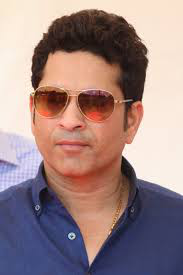

In [297]:
Image.open('/content/lfw_funneled/sachin/sachin2.jpg')

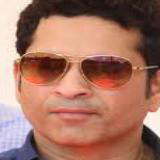

In [298]:
Image.open('/content/lfw_funneled_aligned/sachin/sachin2.jpg')

In [173]:
!cp -R /content/lfw_funneled_aligned_train/ /content/drive/My\ Drive/VisionUtils/datasets/

In [174]:
!cp -R /content/lfw_funneled_aligned_valid/ /content/drive/My\ Drive/VisionUtils/datasets/

## Using aligned dataset and Creating Dataloaders

In [8]:
#!rm -rf /content/lfw_funneled_aligned_train/ /content/lfw_funneled_aligned_valid/
trn_dir = '/content/lfw_funneled_aligned_train/'
val_dir = '/content/lfw_funneled_aligned_valid/'
os.makedirs(trn_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
for root,_,files in progress_bar(os.walk('/content/lfw_funneled_aligned'),total = len(os.listdir('/content/lfw_funneled_aligned'))):
    N = len(files)
    np.random.shuffle(files)
    val_size = int(0.3*N)
    trn_size = N-val_size
    val_files = files[:val_size]
    trn_files = files[val_size:]
    for f in files:
        if f in val_files:
            os.makedirs(val_dir+root.split('/')[-1],exist_ok=True)
            shutil.copy2(os.path.join(root,f),os.path.join(val_dir+root.split('/')[-1],f))
        else:
            os.makedirs(trn_dir+root.split('/')[-1],exist_ok=True)
            shutil.copy2(os.path.join(root,f),os.path.join(trn_dir+root.split('/')[-1],f))


In [ ]:
!zip -r lfw_funneled_aligned_train.zip lfw_funneled_aligned_train

In [ ]:
!zip -r lfw_funneled_aligned_valid.zip lfw_funneled_aligned_valid

In [12]:
!cp lfw_funneled_aligned_train.zip /content/drive/My\ Drive/VisionUtils/.
!cp lfw_funneled_aligned_valid.zip /content/drive/My\ Drive/VisionUtils/.

In [13]:
trn_tfms = Compose([RandomHorizontalFlip(),
                    RandomRotation((-5,5)),
                    CenterCrop((160,160)),
                    ToTensor(),
                    Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])])
val_tfms = Compose([ToTensor(),
                    Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])])

In [14]:
trn_ds = ImageFolder(root='/content/lfw_funneled_aligned_train',transform=trn_tfms)
val_ds = ImageFolder(root='/content/lfw_funneled_aligned_valid',transform=val_tfms)

In [15]:
BATCH_SIZE = 64
dl_args = dict(shuffle=True,num_workers=8,pin_memory=True,batch_size=BATCH_SIZE)
trn_dl = DataLoader(trn_ds,**dl_args)
val_dl = DataLoader(val_ds,**dl_args)

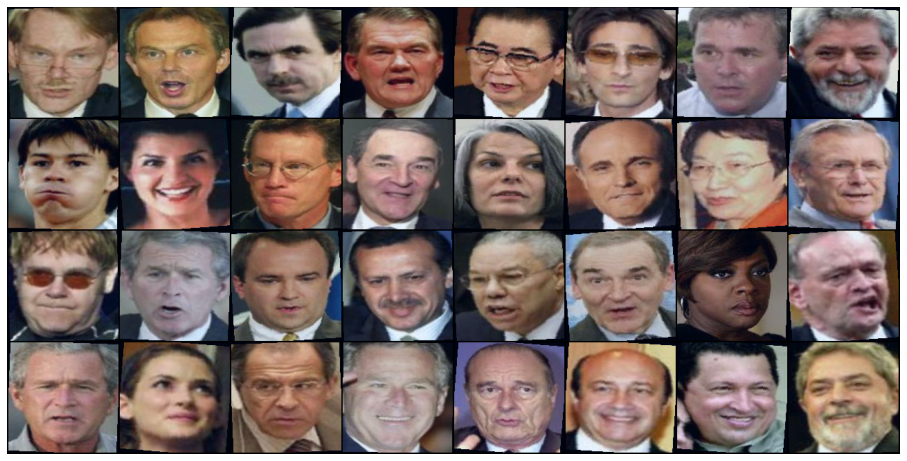

In [303]:
show_batch(trn_dl)

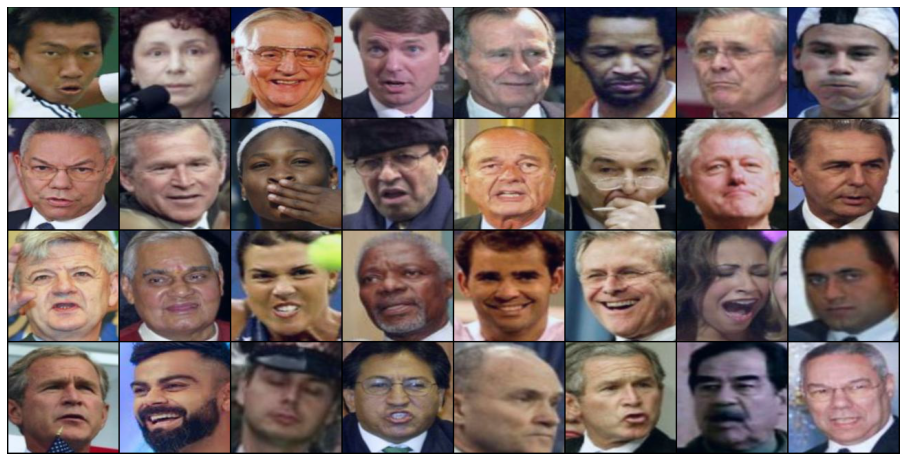

In [304]:
show_batch(val_dl)

## Model

In [216]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.view(x.size(0),-1)

class CustomNormalize(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        x = F.normalize(x,dim=1,p=2)
        return x


class CustomFaceNetModel(nn.Module):
    def __init__(self,num_classes,ModelClassName = InceptionResnetV1,finetuning=False,cut=-5,pretrained='vggface2'):
        super().__init__()
        self.num_classes = num_classes
        model = InceptionResnetV1(pretrained=pretrained,num_classes=num_classes,classify=True)
        frozen_layers = list(model.children())[:cut]
        final_layers = list(model.children())[cut:]
        self.model_ft = nn.Sequential(*frozen_layers)
        if not finetuning:
            for p in self.model_ft.parameters():
                p.requires_grad = False
        # add average pooling 
        self.model_ft.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.model_ft.last_linear = nn.Sequential(*[Flatten(),nn.Linear(1792,512),CustomNormalize()])
        self.model_ft.logits = nn.Linear(512,num_classes)
    
    def forward(self,x):
        x = self.model_ft(x)
        return x


In [217]:
model_ft = CustomFaceNetModel(num_classes = len(trn_ds.classes))

## Finding Lr

In [228]:
model = CustomFaceNetModel(num_classes = len(trn_ds.classes)).cuda()

In [229]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [230]:
for p in model.parameters():
    if p.requires_grad:
        print(p.size())

torch.Size([512, 1792])
torch.Size([512])
torch.Size([422, 512])
torch.Size([422])


In [231]:
finder = train.LRFinder(model,opt,loss_func)

In [232]:
finder.range_test(trn_dl,start_lr=1e-6,end_lr=10,num_iter=1000)

 82%|████████▏ | 823/1000 [02:59<00:33,  5.24it/s]

Stopping early as the loss has started to diverge
Learning rate search is over. Please use self.plot to look at the graph


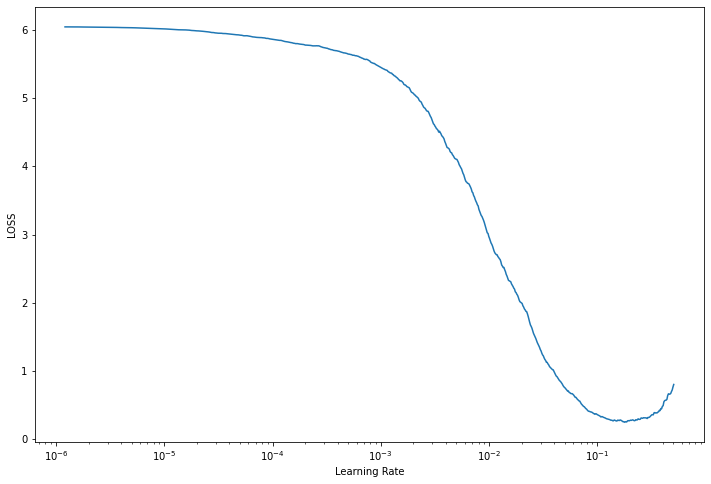

In [233]:
finder.plot()

## Training the Model

In [305]:
model = CustomFaceNetModel(num_classes = len(trn_ds.classes)).cuda()

In [306]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())
sched = OneCycleLR(opt,5e-2,epochs=40,steps_per_epoch=len(trn_dl),div_factor=25.,final_div_factor=100)

In [307]:
dls = dict(train=trn_dl,valid=val_dl)

1 (2,)


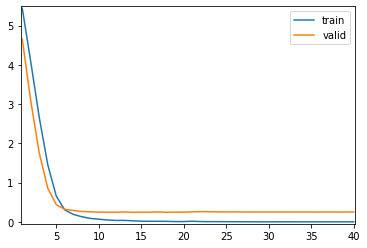

2 (4,)
3 (6,)
4 (8,)
5 (10,)
6 (12,)
7 (14,)
8 (16,)
9 (18,)
10 (20,)
11 (22,)
12 (24,)
13 (26,)
14 (28,)
15 (30,)
16 (32,)
17 (34,)
18 (36,)
19 (38,)
20 (40,)
21 (42,)
22 (44,)
23 (46,)
24 (48,)
25 (50,)
26 (52,)
27 (54,)
28 (56,)
29 (58,)
30 (60,)
31 (62,)
32 (64,)
33 (66,)
34 (68,)
35 (70,)
36 (72,)
37 (74,)
38 (76,)
39 (78,)
40 (80,)


In [308]:
results = train.train(model,opt,dls,loss_func,40,scheduler=sched,sched_batchwise=True)

In [309]:
model.eval()

CustomFaceNetModel(
  (model_ft): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [310]:
model.cpu()

CustomFaceNetModel(
  (model_ft): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [311]:
next(model.parameters()).device

device(type='cpu')

In [315]:
cpu_model = torch.jit.trace(model,torch.randn(1,3,160,160))

In [317]:
cpu_model.save('/content/drive/My Drive/EVA/facemodel_optimized_jit.pt')

In [319]:
cpu_model.save('/content/facemodel_optimized_jit.pt')

In [318]:
torch.save(model.state_dict(),'face_optimized.pt')

In [320]:
torch.save(model.state_dict(),'/content/drive/My Drive/EVA/facemodel_optimized.pt')

## Evaluating Model

In [17]:
model = models.CustomFaceNetModel(num_classes = len(trn_ds.classes)).cuda()

In [18]:
model.load_state_dict(torch.load('/content/drive/My Drive/EVA/facemodel_optimized.pt'))

<All keys matched successfully>

In [ ]:
trn_ds = ImageFolder(root='/content/lfw_funneled_aligned_train',transform=val_tfms)
val_ds = ImageFolder(root='/content/lfw_funneled_aligned_valid',transform=val_tfms)

In [19]:
import facenet_pytorch